## Basic Text Classification

In [5]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

print(tf.__version__)

url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
dataset_dir

2.4.0
84131840/84125825 [==============================] - 3s 0us/step


'./aclImdb'

In [13]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

# remove_dir = os.path.join(train_dir, 'unsup')
# shutil.rmtree(remove_dir)
# remove_dir = os.path.join(train_dir, '.ipynb_checkpoints')
# shutil.rmtree(remove_dir)


batch_size = 32
seed = 42
#  create a validation set using an 80:20 split of the training data by using the validation_split argument
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
      'aclImdb/train',
      batch_size=batch_size,
      validation_split=0.2,
      subset='training',
      seed=seed
)

raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

raw_train_ds.class_names

['labeledBow.feat',
 'urls_unsup.txt',
 'pos',
 'urls_neg.txt',
 'unsupBow.feat',
 'neg',
 'urls_pos.txt']

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.
Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


['neg', 'pos']

In [14]:
## Tokenization and vectorization
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

Review tf.Tensor(b"Having seen most of Ringo Lam's films, I can say that this is his best film to date, and the most unusual. It's a ancient china period piece cranked full of kick-ass martial arts, where the location of an underground lair full of traps and dungeons plays as big a part as any of the characters. The action is fantastic, the story is tense and entertaining, and the set design is truely memorable. Sadly, Burning Paradise has not been made available on DVD and vhs is next-to-impossible to get your mitts on, even if you near the second biggest china-town in North America (like I do). If you can find it, don't pass it up.", shape=(), dtype=string)
Label pos
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[ 253,  105,   88,    5,    1,    1,   94,   10,   68,  131,   12,
          11,    7,   24,  113,   19,    6, 1290,    3,    2,   88, 1603,
          29,    4, 2216, 2674,  840,  411,    1,  374,    5,    1, 1691,
        1741,  114,    2, 1652,  

In [15]:
## Two important methods you should use when loading data to make sure that I/O does not become blocking.
# cache() and prefetch()
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [18]:
embedding_dim = 16

# average the embedding of all words together to form one vector for the sentence.

model = tf.keras.Sequential([layers.Embedding(max_features+1, embedding_dim),
                             layers.Dropout(0.2),
                             layers.GlobalAveragePooling1D(),
                             layers.Dropout(0.2),
                             layers.Dense(1)])
model.summary()

model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
             optimizer='adam', metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

epochs = 10
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160016    
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d_2 ( (None, 16)                0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 5s 7ms/step - loss: 0.6821 - binary_accuracy: 0.6159 - val_l

In [21]:
loss, accuracy = model.evaluate(test_ds)
print(f"Loss: {loss} ... Accuracy {accuracy}")

782/782 [==============================] - 1s 1ms/step - loss: 0.3096 - binary_accuracy: 0.8737
Loss: 0.30963557958602905 ... Accuracy 0.8737199902534485


Text(0.5, 1.0, 'Training and validation loss')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

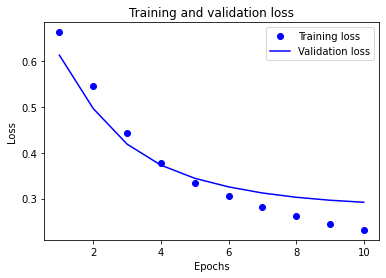

Text(0.5, 1.0, 'Training and validation accuracy')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Accuracy')

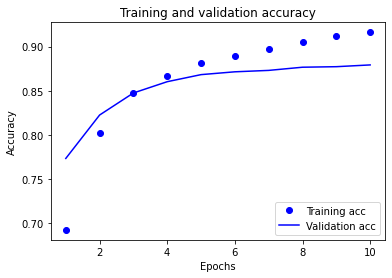

In [24]:
history_dict = history.history

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [27]:
# include the vectorization layer to have the model operate directly on raw strings
export_model = tf.keras.Sequential([vectorize_layer, model, layers.Activation('sigmoid')])
export_model.compile(loss=losses.BinaryCrossentropy(from_logits=False),
                    optimizer='adam', metrics=['accuracy'])
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

782/782 [==============================] - 5s 7ms/step - loss: 0.3105 - accuracy: 0.8739
0.8737199902534485


array([[0.61909986],
       [0.4411755 ],
       [0.3571025 ]], dtype=float32)

## StackOverflow


In [30]:
  
url = "http://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

dataset = tf.keras.utils.get_file("stack_overflow_16k.tar.gz", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'stack_overflow_16k')